In [3]:
#%%time
""" 
    Apprentice Chef Case
    Regression Model Building for DAT-5304 Machine Learning.
    The course is part of the MS. in Business Analytics at HULT International
    Business School.
    
    Author: Maximilian Paulus
    Submission Date: January 27, 2020"""

""" 
DocString:
    a) Introduction:
    This Document contains a streamlined version of the exploratory data analysis,
    feature engineering, model building, selection and tuning, that was performed
    within the scope of predicting revenues from Apprentice Chef Customers.
    
    b) Known Errors or Bugs:
        -
"""
# Importing Required Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf # linear regression (statsmodels)
import sklearn.linear_model # linear models
from scipy.stats import randint
from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model import LinearRegression # linear regression (scikit-learn)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Importing Apprentice Chef Dataset
filename = 'Apprentice_Chef_Dataset.xlsx'

chef_df = pd.read_excel(filename)

# chef_df.head()
# chef_df.loc[:, :].quantile([0.20,
#                            0.40,
#                            0.60,
#                            0.80,
#                            1.00])

# chef_df.info()

# chef_df.describe().round(2)









##############################################################################







CPU times: user 1.69 s, sys: 638 ms, total: 2.33 s
Wall time: 3.54 s


In [22]:
chef_df.loc[:, :].quantile([0.20,
                           0.40,
                           0.60,
                           0.80,
                           1.00])

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,...,CHANGE_TOTAL_PHOTOS_VIEWED,CHANGE_WEEKLY_PLAN,CHANGE_MEDIAN_MEAL_RATING,CHANGE_UNIQUE_MEALS_PURCH,PCT_EARLY_DELIVERIES,PCT_LATE_DELIVERIES,EVER_RATED,PCT_WEEKLY_PLAN,ATTENDED_CLASS,AVG_MEALS_MONTH
0.2,1285.00,0.0,35.0,3.0,5.0,2.0,61.58,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.000000,0.008547,1.0,0.000000,0.0,2.916667
0.4,1558.00,1.0,51.0,4.0,6.0,4.0,86.51,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.000000,0.025547,1.0,0.194805,0.0,4.250000
0.6,1910.00,1.0,71.0,6.0,7.0,6.0,102.62,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.003311,0.051282,1.0,0.464286,1.0,5.916667
0.8,2895.00,1.0,106.0,7.0,9.0,9.0,123.80,1.0,2.0,0.0,...,1.0,1.0,0.0,1.0,0.052632,0.097561,1.0,1.088710,1.0,8.833333
1.0,8793.75,1.0,493.0,19.0,18.0,10.0,1645.60,1.0,13.0,3.0,...,1.0,1.0,1.0,1.0,0.750000,1.250000,1.0,11.538462,1.0,41.083333


In [29]:
chef_df['IS_PROFESSIONAL'].value_counts()

0.0    1250
1.0     696
Name: IS_PROFESSIONAL, dtype: int64

In [28]:
chef_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 60 columns):
REVENUE                               1946 non-null float64
CROSS_SELL_SUCCESS                    1946 non-null int64
NAME                                  1946 non-null object
EMAIL                                 1946 non-null object
FIRST_NAME                            1946 non-null object
FAMILY_NAME                           1946 non-null object
TOTAL_MEALS_ORDERED                   1946 non-null int64
UNIQUE_MEALS_PURCH                    1946 non-null int64
CONTACTS_W_CUSTOMER_SERVICE           1946 non-null int64
PRODUCT_CATEGORIES_VIEWED             1946 non-null int64
AVG_TIME_PER_SITE_VISIT               1946 non-null float64
MOBILE_NUMBER                         1946 non-null int64
CANCELLATIONS_BEFORE_NOON             1946 non-null int64
CANCELLATIONS_AFTER_NOON              1946 non-null int64
TASTES_AND_PREFERENCES                1946 non-null int64
MOBILE_LOGINS  

Checking for missing values and imputing missing family names with 'n/a'

In [4]:

# Checking for missing values, creating missing value flag and imputing missing family names
# chef_df.isna().sum()

if chef_df['FAMILY_NAME'].isnull().astype(int).sum() > 0:
    chef_df['MISSING_FAMILY_NAME'] = chef_df['FAMILY_NAME'].isnull().astype(int)
fill = 'n/a'
chef_df['FAMILY_NAME'] = chef_df['FAMILY_NAME'].fillna(fill)

The target variable for the subsequent analysis is 'CROSS_SELL_SUCCESS'. Looking at the value counts checks for class imbalance (only very few observations for one of the classes). The classes in this case are 0 and 1, representing cross sell success and not success

In [17]:
chef_df['CROSS_SELL_SUCCESS'].value_counts()

1    1321
0     625
Name: CROSS_SELL_SUCCESS, dtype: int64

Given the value counts of 1321 and 625 there is no class imbalance underlying that would require special care in the analysis

Splitting email adresses into address and domain section to classify domains as personal, professional or spam

In [27]:

# Splitting Email Addresses into address and domain
# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_df.iterrows():
    
    # splitting email domain at '@'
    split_email = chef_df.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)
email_df.columns = ['EMAIL_ADDRESS', 'DOMAIN']
chef_df['EMAIL_ADDRESS'] = email_df['EMAIL_ADDRESS']
chef_df['DOMAIN'] = email_df['DOMAIN']

# displaying the results
# chef_df

# Classyfing Domains into personal and non-personal

personal_mail_list = ['gmail.com', 'yahoo.com', 'protonmail.com']
junk_mail_list = ['me.com','aol.com','hotmail.com','live.com','msn.com','passport.com']

for index, col in chef_df.iterrows():
    if chef_df.loc[index, 'DOMAIN'] in personal_mail_list:
        chef_df.loc[index, 'IS_PERSONAL'] = int(1)
    else:
        chef_df.loc[index, 'IS_PERSONAL'] = int(0)
chef_df['IS_PERSONAL'] = chef_df['IS_PERSONAL'].astype('int64')       


for index, col in chef_df.iterrows():
    if chef_df.loc[index, 'DOMAIN'] in junk_mail_list:
        chef_df.loc[index, 'IS_SPAM'] = int(1)
    else:
        chef_df.loc[index, 'IS_SPAM'] = int(0)
chef_df['IS_SPAM'] = chef_df['IS_SPAM'].astype('int64')  

for index, col in chef_df.iterrows():
    if chef_df.loc[index, 'DOMAIN'] not in junk_mail_list and chef_df.loc[index, 'DOMAIN'] not in personal_mail_list:
        chef_df.loc[index, 'IS_PROFESSIONAL'] = int(1)
    else:
        chef_df.loc[index, 'IS_PROFESSIONAL'] = int(0)
        
chef_df['IS_SPAM'] = chef_df['IS_SPAM'].astype('int64') 

chef_df.head()

,REVENUE,CROSS_SELL_SUCCESS,NAME,EMAIL,FIRST_NAME,FAMILY_NAME,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,...,CHANGE_WEEKLY_PLAN,CHANGE_MEDIAN_MEAL_RATING,CHANGE_UNIQUE_MEALS_PURCH,PCT_EARLY_DELIVERIES,PCT_LATE_DELIVERIES,EVER_RATED,PCT_WEEKLY_PLAN,ATTENDED_CLASS,AVG_MEALS_MONTH,IS_PROFESSIONAL
0,1880.0,1,Addam Osgrey,addam.osgrey@passport.com,Addam,Osgrey,118,4,7,5,...,1,0,1,0.000000,0.016949,1,0.203390,1,9.833333,0.0
1,1495.0,1,Aegon Blackfyre,aegon.blackfyre@jnj.com,Aegon,Blackfyre,44,3,6,3,...,1,0,1,0.000000,0.090909,1,0.545455,1,3.666667,1.0
2,2572.5,1,Aegon Frey (son of Aenys),aegon.frey.(son.of.aenys)@gmail.com,Aegon,Frey,38,1,5,3,...,1,0,0,0.000000,0.000000,1,1.105263,0,3.166667,0.0
3,1647.0,1,Aegon Targaryen (son of Rhaegar),aegon.targaryen.(son.of.rhaegar)@ibm.com,Aegon,Targaryen,76,3,8,10,...,1,0,1,0.065789,0.052632,1,0.434211,0,6.333333,1.0
4,1923.0,1,Aegon V Targaryen,aegon.v.targaryen@goldmansacs.com,Aegon,V Targaryen,65,3,6,9,...,1,0,1,0.000000,0.061538,1,0.553846,1,5.416667,1.0


Calculating fields based on existing features. The following new features could be interesting to look at:
    
    1. Percentage of early deliveries (early deliveries / total deliveries)
    2. Percentage of late deliveries (late deliveries / total deliveries)
    3. Did the customer ever give a rating? (median_rating > 0)
    4. Percentage of meals from weekly plan (assuming basic weekly plan = 3 meals)
    5. Did customer attend cooking class? (0 and 1 encoding)
    6. Average meals per month
    

In [20]:
# Feature 1: percentage of early deliveries
for index, col in chef_df.iterrows():
    chef_df.loc[index,'PCT_EARLY_DELIVERIES'] = chef_df.loc[index,'EARLY_DELIVERIES'] / chef_df.loc[index,'TOTAL_MEALS_ORDERED']

    
# Feature 2:
for index, col in chef_df.iterrows():
    chef_df.loc[index,'PCT_LATE_DELIVERIES'] = chef_df.loc[index,'LATE_DELIVERIES'] / chef_df.loc[index,'TOTAL_MEALS_ORDERED']

    
# Feature 3: did the customer ever give a rating?
for index, col in chef_df.iterrows():
    if chef_df.loc[index, 'MEDIAN_MEAL_RATING'] > 0:
        chef_df.loc[index, 'EVER_RATED'] = int(1)
    else:
        chef_df.loc[index, 'EVER_RATED'] = int(0)


# Feature 4: percentage of meals from weekly plan
for index, col in chef_df.iterrows():
    chef_df.loc[index,'PCT_WEEKLY_PLAN'] = chef_df.loc[index,'WEEKLY_PLAN']*3 / chef_df.loc[index,'TOTAL_MEALS_ORDERED']


# Feature 5: did the customer attend cooking class?
for index, col in chef_df.iterrows():
    if chef_df.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        chef_df.loc[index, 'ATTENDED_CLASS'] = int(1)
    else:
        chef_df.loc[index, 'ATTENDED_CLASS'] = int(0)
    
chef_df['ATTENDED_CLASS'] = chef_df['ATTENDED_CLASS'].astype('int64')  


# Feature 6: average meals per month
for index, col in chef_df.iterrows():
    chef_df.loc[index,'AVG_MEALS_MONTH'] = chef_df.loc[index,'TOTAL_MEALS_ORDERED'] / 12

In [30]:
chef_df_corr_cross = chef_df.corr()
chef_df_corr_cross['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS                    1.000000
FOLLOWED_RECOMMENDATIONS_PCT          0.464387
IS_PROFESSIONAL                       0.194102
CANCELLATIONS_BEFORE_NOON             0.163442
MOBILE_NUMBER                         0.102657
TASTES_AND_PREFERENCES                0.081438
REFRIGERATED_LOCKER                   0.068321
OUT_CANCELLATIONS_BEFORE_NOON         0.060200
OUT_AVG_PREP_VID_TIME                 0.053733
ATTENDED_CLASS                        0.049939
MOBILE_LOGINS                         0.044462
PACKAGE_LOCKER                        0.043534
IS_PERSONAL                           0.038841
MASTER_CLASSES_ATTENDED               0.037213
CONTACTS_W_CUSTOMER_SERVICE           0.036541
AVG_PREP_VID_TIME                     0.032115
MEDIAN_MEAL_RATING                    0.031798
OUT_CONTACTS_W_CUSTOMER_SERVICE       0.030803
CHANGE_UNIQUE_MEALS_PURCH             0.028760
CHANGE_MEDIAN_MEAL_RATING             0.024337
LARGEST_ORDER_SIZE                    0.022000
OUT_LATE_DELI

Visual EDA with scatterplots to find outlier thresholds and create feature columns flagging outlierts

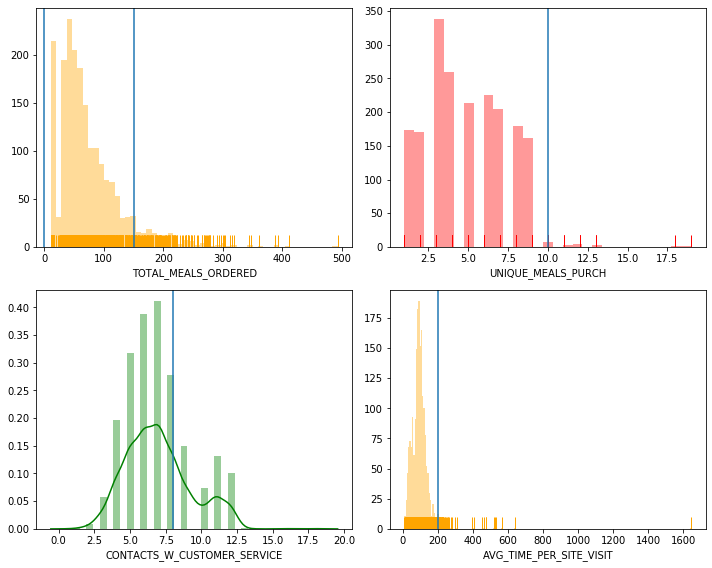

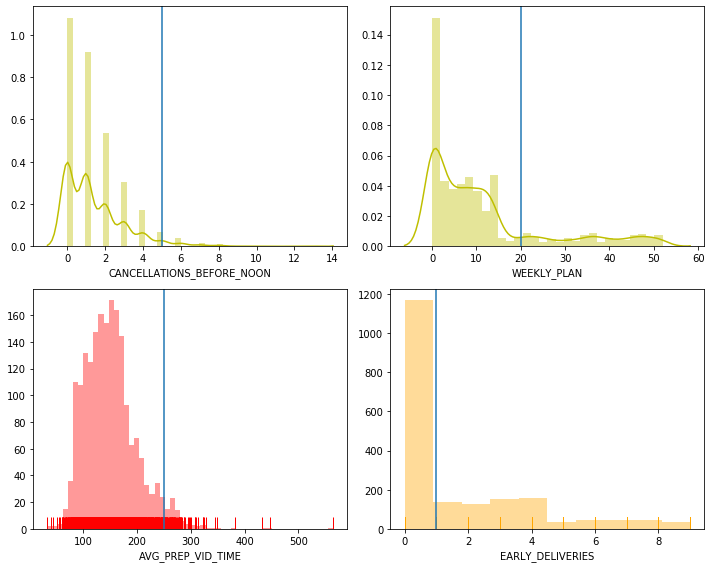

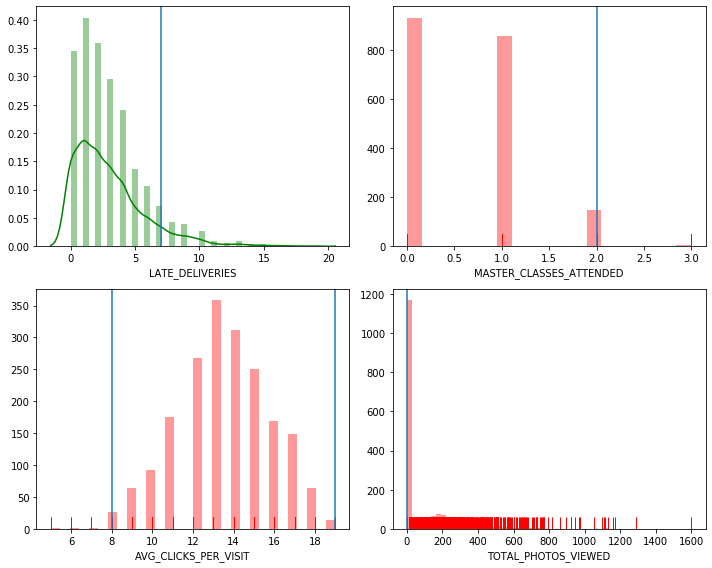

In [14]:
##############################################################################
# Visual EDA (Histograms)
########################
# Setting Outlier Thresholds

total_meals_hi = 150
total_meals_lo = 0
unique_meals_hi = 10
customer_service_hi = 8
avg_time_hi = 200
cancellations_before_hi = 5
weekly_plan_hi = 20
prep_vid_time_hi = 250
late_deliveries_hi = 7
early_deliveries_hi = 1
master_classes_hi = 2
avg_clicks_lo = 8
avg_clicks_hi = 19
total_photos_hi = 1


fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef_df['TOTAL_MEALS_ORDERED'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.xlabel('TOTAL_MEALS_ORDERED')
plt.axvline(x = total_meals_hi)
plt.axvline(x = total_meals_lo)

########################

plt.subplot(2, 2, 2)
sns.distplot(chef_df['UNIQUE_MEALS_PURCH'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('UNIQUE_MEALS_PURCH')
plt.axvline(x = unique_meals_hi)

########################

plt.subplot(2, 2, 3)
sns.distplot(chef_df['CONTACTS_W_CUSTOMER_SERVICE'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('CONTACTS_W_CUSTOMER_SERVICE')
plt.axvline(x = customer_service_hi)

########################
plt.subplot(2, 2, 4)
sns.distplot(chef_df['AVG_TIME_PER_SITE_VISIT'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'orange')
plt.axvline(x = avg_time_hi)
plt.xlabel('AVG_TIME_PER_SITE_VISIT')
plt.tight_layout()
plt.savefig('Apprentice Chef Final Histograms 1 of 3.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef_df['CANCELLATIONS_BEFORE_NOON'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('CANCELLATIONS_BEFORE_NOON')
plt.axvline(x = cancellations_before_hi)

########################

plt.subplot(2, 2, 2)
sns.distplot(chef_df['WEEKLY_PLAN'],
             bins  = 'fd',
             color = 'y')
plt.xlabel('WEEKLY_PLAN')
plt.axvline(x = weekly_plan_hi)

########################

plt.subplot(2, 2, 3)
sns.distplot(chef_df['AVG_PREP_VID_TIME'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('AVG_PREP_VID_TIME')
plt.axvline(x = prep_vid_time_hi)

########################

plt.subplot(2, 2, 4)
sns.distplot(chef_df['EARLY_DELIVERIES'],
             bins = 10,
             kde  = False,
             rug  = True,
             color = 'orange')
plt.xlabel('EARLY_DELIVERIES')
plt.axvline(x = early_deliveries_hi)
plt.tight_layout()
plt.savefig('Apprentice Chef Final Histograms 2 of 3.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.distplot(chef_df['LATE_DELIVERIES'],
             bins  = 'fd',
             color = 'g')
plt.xlabel('LATE_DELIVERIES')
plt.axvline(x = late_deliveries_hi)

########################

plt.subplot(2, 2, 2)
sns.distplot(chef_df['MASTER_CLASSES_ATTENDED'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('MASTER_CLASSES_ATTENDED')
plt.axvline(x = master_classes_hi)

########################

plt.subplot(2, 2, 3)
sns.distplot(chef_df['AVG_CLICKS_PER_VISIT'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('AVG_CLICKS_PER_VISIT')
plt.axvline(x = avg_clicks_hi)
plt.axvline(x = avg_clicks_lo)

########################

plt.subplot(2, 2, 4)
sns.distplot(chef_df['TOTAL_PHOTOS_VIEWED'],
             bins  = 'fd',
             kde   = False,
             rug   = True,
             color = 'r')
plt.xlabel('TOTAL_PHOTOS_VIEWED')
plt.axvline(x = total_photos_hi)
plt.tight_layout()
plt.savefig('Apprentice Chef Final Histograms 3 of 3.png')
plt.show()


##############################################################################
# developing features (columns) for outliers

# Total Meals
chef_df['OUT_TOTAL_MEALS_ORDERED'] = 0
condition_hi = chef_df.loc[0:,'OUT_TOTAL_MEALS_ORDERED'][chef_df['TOTAL_MEALS_ORDERED'] > total_meals_hi]
condition_lo = chef_df.loc[0:,'OUT_TOTAL_MEALS_ORDERED'][chef_df['TOTAL_MEALS_ORDERED'] <= total_meals_lo]

chef_df['OUT_TOTAL_MEALS_ORDERED'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

chef_df['OUT_TOTAL_MEALS_ORDERED'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)
# Unique Meals
chef_df['OUT_UNIQUE_MEALS_PURCH'] = 0
condition_hi = chef_df.loc[0:,'OUT_UNIQUE_MEALS_PURCH'][chef_df['UNIQUE_MEALS_PURCH'] > unique_meals_hi]

chef_df['OUT_UNIQUE_MEALS_PURCH'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Customer Service
chef_df['OUT_CONTACTS_W_CUSTOMER_SERVICE'] = 0
condition_hi = chef_df.loc[0:,'OUT_CONTACTS_W_CUSTOMER_SERVICE'][chef_df['CONTACTS_W_CUSTOMER_SERVICE'] > customer_service_hi]

chef_df['OUT_CONTACTS_W_CUSTOMER_SERVICE'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Cancellations before Noon
chef_df['OUT_CANCELLATIONS_BEFORE_NOON'] = 0
condition_hi = chef_df.loc[0:,'OUT_CANCELLATIONS_BEFORE_NOON'][chef_df['CANCELLATIONS_BEFORE_NOON'] > cancellations_before_hi]

chef_df['OUT_CANCELLATIONS_BEFORE_NOON'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Weekly Plan
chef_df['OUT_WEEKLY_PLAN'] = 0
condition_hi = chef_df.loc[0:,'OUT_WEEKLY_PLAN'][chef_df['WEEKLY_PLAN'] > weekly_plan_hi]

chef_df['OUT_WEEKLY_PLAN'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Prep Vid Time
chef_df['OUT_AVG_PREP_VID_TIME'] = 0
condition_hi = chef_df.loc[0:,'OUT_AVG_PREP_VID_TIME'][chef_df['AVG_PREP_VID_TIME'] > prep_vid_time_hi]

chef_df['OUT_AVG_PREP_VID_TIME'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Late Deliveries
chef_df['OUT_LATE_DELIVERIES'] = 0
condition_hi = chef_df.loc[0:,'OUT_LATE_DELIVERIES'][chef_df['LATE_DELIVERIES'] > late_deliveries_hi]

chef_df['OUT_LATE_DELIVERIES'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)
# Early Deliveries
chef_df['OUT_EARLY_DELIVERIES'] = 0
condition_hi = chef_df.loc[0:,'OUT_EARLY_DELIVERIES'][chef_df['EARLY_DELIVERIES'] > early_deliveries_hi]

chef_df['OUT_EARLY_DELIVERIES'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Avg Time
chef_df['OUT_AVG_TIME_PER_SITE_VISIT'] = 0
condition_hi = chef_df.loc[0:,'OUT_AVG_TIME_PER_SITE_VISIT'][chef_df['AVG_TIME_PER_SITE_VISIT'] > avg_time_hi]

chef_df['OUT_AVG_TIME_PER_SITE_VISIT'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Master Classes
chef_df['OUT_MASTER_CLASSES_ATTENDED'] = 0
condition_hi = chef_df.loc[0:,'OUT_MASTER_CLASSES_ATTENDED'][chef_df['MASTER_CLASSES_ATTENDED'] > master_classes_hi]

chef_df['OUT_MASTER_CLASSES_ATTENDED'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

# Average Clicks
chef_df['OUT_AVG_CLICKS_PER_VISIT'] = 0
condition_hi = chef_df.loc[0:,'OUT_AVG_CLICKS_PER_VISIT'][chef_df['AVG_CLICKS_PER_VISIT'] > avg_clicks_hi]
condition_lo = chef_df.loc[0:,'OUT_AVG_CLICKS_PER_VISIT'][chef_df['AVG_CLICKS_PER_VISIT'] < avg_clicks_lo]


chef_df['OUT_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)
chef_df['OUT_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition_lo,
                                value      = 1,
                                inplace    = True)

# Total Photos
chef_df['OUT_TOTAL_PHOTOS_VIEWED'] = 0
condition_hi = chef_df.loc[0:,'OUT_TOTAL_PHOTOS_VIEWED'][chef_df['TOTAL_PHOTOS_VIEWED'] > total_photos_hi]

chef_df['OUT_TOTAL_PHOTOS_VIEWED'].replace(to_replace = condition_hi,
                                value      = 1,
                                inplace    = True)

Checking for trends in the data and creating trend based feature columns

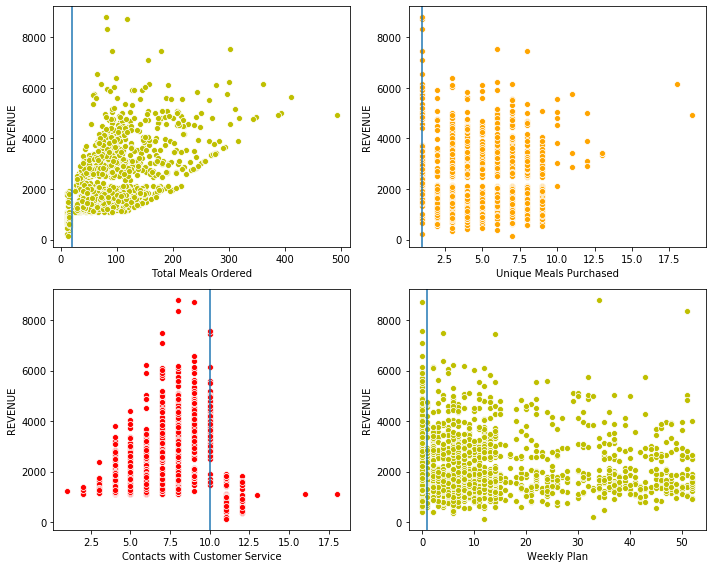

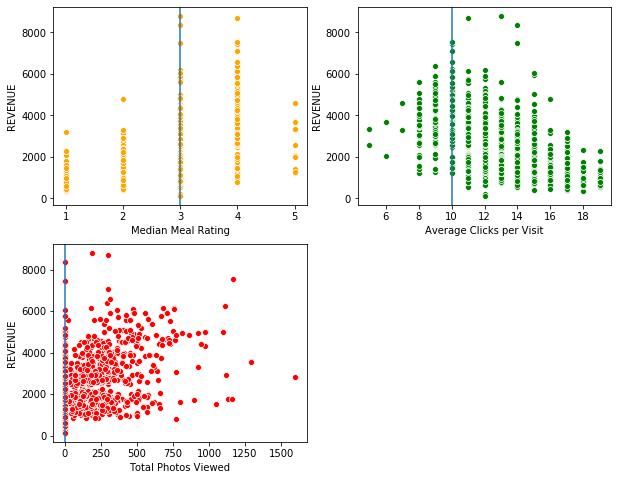

In [15]:
# trend change markers:
change_total_meals_ordered_hi = 20
change_unique_meals_purch_hi = 1
change_contacts_w_customer_service_hi = 10
change_avg_clicks_per_visit_hi = 10
change_total_photos_viewed_lo = 0

change_weekly_plan_hi = 1

change_median_meal_rating_hi = 3

########################
# Visual EDA (Scatterplots)
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(x = chef_df['TOTAL_MEALS_ORDERED'],
                y = chef_df['REVENUE'],
                color = 'y')
plt.xlabel('Total Meals Ordered')
plt.axvline(x=change_total_meals_ordered_hi)

########################

plt.subplot(2, 2, 2)
sns.scatterplot(x = chef_df['UNIQUE_MEALS_PURCH'],
                y = chef_df['REVENUE'],
                color = 'orange')
plt.axvline(x = change_unique_meals_purch_hi)
plt.xlabel('Unique Meals Purchased')

########################

plt.subplot(2, 2, 3)
sns.scatterplot(x = chef_df['CONTACTS_W_CUSTOMER_SERVICE'],
                y = chef_df['REVENUE'],
                color = 'r')
plt.xlabel('Contacts with Customer Service')
plt.axvline(x = change_contacts_w_customer_service_hi)

########################
plt.subplot(2, 2, 4)
sns.scatterplot(x = chef_df['WEEKLY_PLAN'],
                y = chef_df['REVENUE'],
                color = 'y')
plt.xlabel('Weekly Plan')
plt.axvline(x = change_weekly_plan_hi)

plt.tight_layout()
plt.savefig('Apprentice Chef Final Scatterplots 1 of 2.png')
plt.show()

########################
########################

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(x = chef_df['MEDIAN_MEAL_RATING'],
                y = chef_df['REVENUE'],
                color = 'orange')
plt.axvline(x = change_median_meal_rating_hi)
plt.xlabel('Median Meal Rating')

########################

plt.subplot(2, 2, 2)
sns.scatterplot(x = chef_df['AVG_CLICKS_PER_VISIT'],
                y = chef_df['REVENUE'],
                color = 'g')
plt.xlabel('Average Clicks per Visit')
plt.axvline(x = change_avg_clicks_per_visit_hi)

########################

plt.subplot(2, 2, 3)
sns.scatterplot(x = chef_df['TOTAL_PHOTOS_VIEWED'],
                y = chef_df['REVENUE'],
                color = 'r')
plt.xlabel('Total Photos Viewed')
plt.axvline(x = change_total_photos_viewed_lo)

plt.savefig('Apprentice Chef Final Scatterplots 2 of 2.png')
plt.show()



##############################################################################
# developing feature columns for trend changes



chef_df['CHANGE_TOTAL_MEALS_ORDERED'] = 0
condition = chef_df.loc[0:,'CHANGE_TOTAL_MEALS_ORDERED'][chef_df['TOTAL_MEALS_ORDERED'] > change_total_meals_ordered_hi]

chef_df['CHANGE_TOTAL_MEALS_ORDERED'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)

chef_df['CHANGE_CONTACTS_W_CUSTOMER_SERVICE'] = 0
condition = chef_df.loc[0:,'CHANGE_CONTACTS_W_CUSTOMER_SERVICE'][chef_df['CONTACTS_W_CUSTOMER_SERVICE'] > change_contacts_w_customer_service_hi]

chef_df['CHANGE_CONTACTS_W_CUSTOMER_SERVICE'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)

chef_df['CHANGE_AVG_CLICKS_PER_VISIT'] = 0
condition = chef_df.loc[0:,'CHANGE_AVG_CLICKS_PER_VISIT'][chef_df['AVG_CLICKS_PER_VISIT'] > change_avg_clicks_per_visit_hi]

chef_df['CHANGE_AVG_CLICKS_PER_VISIT'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)

chef_df['CHANGE_TOTAL_PHOTOS_VIEWED'] = 0
condition = chef_df.loc[0:,'CHANGE_TOTAL_PHOTOS_VIEWED'][chef_df['TOTAL_PHOTOS_VIEWED'] <= change_total_photos_viewed_lo]

chef_df['CHANGE_TOTAL_PHOTOS_VIEWED'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)

chef_df['CHANGE_WEEKLY_PLAN'] = 0
condition = chef_df.loc[0:,'CHANGE_WEEKLY_PLAN'][chef_df['WEEKLY_PLAN'] > change_weekly_plan_hi]

chef_df['CHANGE_WEEKLY_PLAN'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)

chef_df['CHANGE_MEDIAN_MEAL_RATING'] = 0
condition = chef_df.loc[0:,'CHANGE_MEDIAN_MEAL_RATING'][chef_df['MEDIAN_MEAL_RATING'] > change_median_meal_rating_hi]

chef_df['CHANGE_MEDIAN_MEAL_RATING'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)

chef_df['CHANGE_UNIQUE_MEALS_PURCH'] = 0
condition = chef_df.loc[0:,'CHANGE_UNIQUE_MEALS_PURCH'][chef_df['UNIQUE_MEALS_PURCH'] > change_unique_meals_purch_hi]

chef_df['CHANGE_UNIQUE_MEALS_PURCH'].replace(to_replace = condition,
                                   value      = 1,
                                   inplace    = True)



Iterating over correlation with Revenue variable to find high correlations 
between explanatory variables and target variable

In [ ]:
##############################################################################
# Creating a correlation heatmap, iteratively narrowing the number of features
# selected for building the model

# correlation heatmap
# chef_df_corr = chef_df[['REVENUE', 'TOTAL_MEALS_ORDERED','AVG_PREP_VID_TIME', 
#                        'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 
#                        'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 
#                        'TOTAL_PHOTOS_VIEWED', 'OUT_TOTAL_MEALS_ORDERED',
#                        'OUT_AVG_PREP_VID_TIME','OUT_TOTAL_PHOTOS_VIEWED', 
#                        'CHANGE_CONTACTS_W_CUSTOMER_SERVICE',
#                        'CHANGE_AVG_CLICKS_PER_VISIT', 
#                        'CHANGE_TOTAL_PHOTOS_VIEWED','CHANGE_UNIQUE_MEALS_PURCH', 
#                        'CHANGE_MEDIAN_MEAL_RATING']]


# df_corr = chef_df_corr.corr().round(2)

# fig, ax = plt.subplots(figsize=(15,15))

# sns.heatmap(df_corr,
#            cmap = 'coolwarm',
#            square = True,
#            annot = True,
#            linecolor = 'black',
#            linewidths = 0.5)


# plt.savefig('Apprentice Chef Heatmap.png')
# plt.show()

Preparing dataset for modeling (test / train split)

In [ ]:
##############################################################################
# Splitting target variable and explanatoriy variables

target_y = chef_df[['REVENUE']]
predictors_x = chef_df[['TOTAL_MEALS_ORDERED','AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 
        'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 
        'TOTAL_PHOTOS_VIEWED', 'OUT_TOTAL_MEALS_ORDERED', 'OUT_AVG_PREP_VID_TIME',
        'OUT_TOTAL_PHOTOS_VIEWED', 'CHANGE_CONTACTS_W_CUSTOMER_SERVICE', 'CHANGE_AVG_CLICKS_PER_VISIT', 
        'CHANGE_TOTAL_PHOTOS_VIEWED', 'CHANGE_UNIQUE_MEALS_PURCH', 'CHANGE_MEDIAN_MEAL_RATING']]

# Splitting Data in Train and Test Set, using 25 % of Data for the test set and a random seed of 222

X_train, X_test, y_train, y_test = train_test_split(predictors_x, target_y, test_size = 0.25, random_state = 222)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

Fitting linear models to compare resulting scores

In [ ]:
##############################################################################
# Comparison of multiple linear models to find the best model
##############################################################################
# INSTANTIATING a model object
lr = LinearRegression()


# FITTING to the training data
lr_fit = lr.fit(X_train, y_train)


# PREDICTING on new data
lr_pred = lr_fit.predict(X_test)


# SCORING the results
print('Linear Training Score:', lr.score(X_train, y_train).round(3))
lr_train_score = lr.score(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)
print('Linear Testing Score:',  lr.score(X_test, y_test).round(3))


##################################################################

# INSTANTIATING a model object
ridge_model = sklearn.linear_model.Ridge()

# FITTING the training data
ridge_fit  = ridge_model.fit(X_train, y_train)


# PREDICTING on new data
ridge_pred = ridge_fit.predict(X_test)

print('Ridge Training Score:', ridge_model.score(X_train, y_train).round(3))
print('Ridge Testing Score:',  ridge_model.score(X_test, y_test).round(3))


# saving scoring data for future use
ridge_train_score = ridge_model.score(X_train, y_train)
ridge_test_score  = ridge_model.score(X_test, y_test)

##################################################################

# INSTANTIATING a model object
lasso_model = sklearn.linear_model.Lasso()

# FITTING the training data
lasso_fit = lasso_model.fit(X_train, y_train)


# PREDICTING on new data
lasso_pred = lasso_fit.predict(X_test)

print('Lasso Training Score:', lasso_model.score(X_train, y_train).round(3))
print('Lasso Testing Score:',  lasso_model.score(X_test, y_test).round(3))


# saving scoring data for future use
lasso_train_score = lasso_model.score(X_train, y_train)
lasso_test_score  = lasso_model.score(X_test, y_test)


##################################################################

# INSTANTIATING a model object
lars_model = sklearn.linear_model.Lars()


# FITTING the training data
lars_fit = lars_model.fit(X_train, y_train)


# PREDICTING on new data
lars_pred = lars_fit.predict(X_test)


print('Lars Training Score:', lars_model.score(X_train, y_train).round(3))
print('Lars Testing Score:',  lars_model.score(X_test, y_test).round(3))


# saving scoring data for future use
lars_train_score = lars_model.score(X_train, y_train)
lars_test_score  = lars_model.score(X_test, y_test)

##################################################################

# INSTANTIATING a model object
llars_model = sklearn.linear_model.LassoLars()


# FITTING the training data
llars_fit = llars_model.fit(X_train, y_train)


# PREDICTING on new data
llars_pred = llars_fit.predict(X_test)


print('Lasso Lars Training Score:', llars_model.score(X_train, y_train).round(3))
print('Lasso Lars Testing Score:',  llars_model.score(X_test, y_test).round(3))


# saving scoring data for future use
ard_train_score = llars_model.score(X_train, y_train)
ard_test_score  = llars_model.score(X_test, y_test)

##################################################################

# INSTANTIATING a model object
multi_model = sklearn.linear_model.MultiTaskElasticNet()


# FITTING the training data
multi_fit = multi_model.fit(X_train, y_train)


# PREDICTING on new data
multi_pred = multi_fit.predict(X_test)


print('Multi Elastic Net Training Score:', multi_model.score(X_train, y_train).round(3))
print('Multi Elastic Net Testing Score:',  multi_model.score(X_test, y_test).round(3))


# saving scoring data for future use
multi_train_score = multi_model.score(X_train, y_train)
multi_test_score  = multi_model.score(X_test, y_test)

##################################################################

# INSTANTIATING a model object
tree_model = sklearn.tree.DecisionTreeRegressor(max_depth = 8)


# FITTING the training data
tree_fit = tree_model.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_fit.predict(X_test)


print('Tree Training Score:', tree_model.score(X_train, y_train).round(3))
print('Tree Testing Score:',  tree_model.score(X_test, y_test).round(3))


# saving scoring data for future use
tree_train_score = tree_model.score(X_train, y_train)
tree_test_score  = tree_model.score(X_test, y_test)
##############################################################################

##############################################################################

Final Model Selection and Result Output

In [ ]:

##############################################################################
# Final Model Selection

# INSTANTIATING a model object
lasso_model = sklearn.linear_model.Lasso()



# FITTING the training data
lasso_fit = lasso_model.fit(X_train, y_train)


# PREDICTING on new data
lasso_pred = lasso_fit.predict(X_test)

print('Lasso Training Score:', lasso_model.score(X_train, y_train).round(3))
print('Lasso Testing Score:',  lasso_model.score(X_test, y_test).round(3))


# saving scoring data for future use
lasso_train_score = lasso_model.score(X_train, y_train)
lasso_test_score  = lasso_model.score(X_test, y_test)

##############################################################################

# Extracting Coefficients from final model
coef = pd.DataFrame(lasso_model.coef_)
columns = pd.DataFrame(X_train.columns)
coef_df = pd.concat([columns, coef], axis = 1)
coef_df.columns = ['Feature', 'Coefficient']
print(coef_df.sort_values('Coefficient', ascending = False))


print("The Final Model has a Testing Score of: ", lasso_model.score(X_test, y_test).round(3))